### A quick demonstration of temperature wiener filtering

In [19]:
import numpy as np
import healpy as hp
from matplotlib.pyplot import *
# from cmblensplus
import basic
import curvedsky
import plottools as pl

In [2]:
# define parameters
Tcmb  = 2.726e6 # CMB temperature
lmax  = 700     # maximum multipole of alm
nside = 512
npix  = 12*nside**2
sigma = 100.    # uK'
L = np.linspace(0,lmax,lmax+1)

In [3]:
# load input cl
cl = basic.aps.read_cambcls('../data/lensedcls.dat',2,lmax,4,bb=True)/Tcmb**2

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/healpy/fitsfunc.py:367: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


W2 correction is 0.7480608622233073


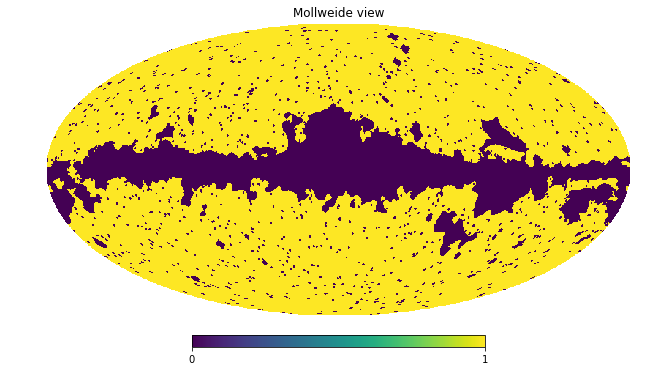

In [4]:
# load mask
mask = hp.fitsfunc.read_map('../data/wmap_temperature_kq85_analysis_mask_r9_9yr_v5.fits',verbose=False)
mask = hp.pixelfunc.ud_grade(mask,nside)
w2 = np.average(mask**2)
print('W2 correction is',w2)
hp.mollview(mask)
show()

In [5]:
# generate Temperature fluctuations
Talm = curvedsky.utils.gauss1alm(lmax,cl[0,:])

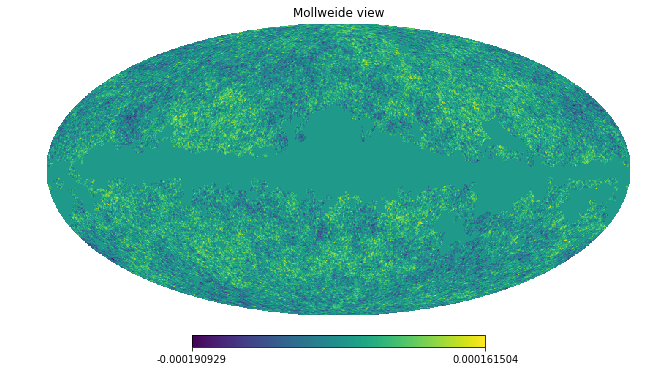

In [6]:
# CMB temperature map with mask
Tmap = mask * curvedsky.utils.hp_alm2map(npix,lmax,lmax,Talm)
Talm = curvedsky.utils.hp_map2alm(nside,lmax,lmax,Tmap)
hp.mollview(Tmap)
show()

In [7]:
# inverse noise covariance
nij  = mask * (sigma*(np.pi/10800.)/Tcmb)**(-2)

In [8]:
# Wiener filtering
xlm0 = curvedsky.cninv.cnfilter(npix,lmax,cl[0,:],nij,Talm,itns=[1000],eps=[1e-6],filter='W')

In [9]:
# Wiener filtering with multigrid preconditioning
lmaxs = [lmax,400,200]
nsides = [nside,256,128]
itns = [1000,10,5]
eps = [1e-6,0.1,0.1]
xlm1 = curvedsky.cninv.cnfilter(npix,lmax,cl[0,:],nij,Talm,3,lmaxs,nsides,itns,eps,filter='W')

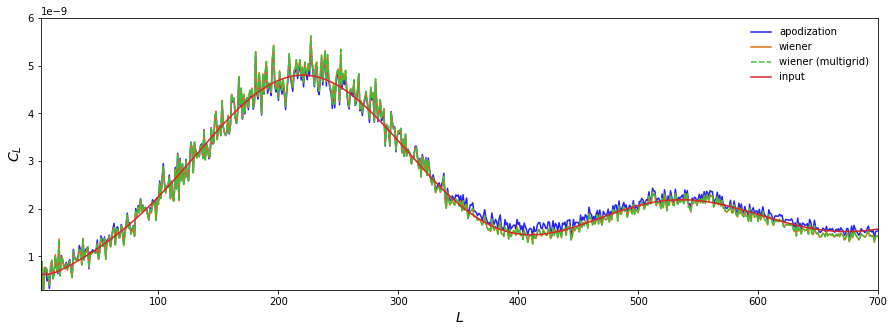

In [33]:
# power spectrum
xl0 = curvedsky.utils.alm2cl(lmax,Talm)/w2
xl1 = curvedsky.utils.alm2cl(lmax,xlm0)/w2
xl2 = curvedsky.utils.alm2cl(lmax,xlm1)/w2
pl.plot_1dstyle(xmin=2,xmax=700,ymin=3e-10,ymax=6e-9,fsize=[15,5])
plot(L,L**2*xl0,label='apodization')
plot(L,L**2*xl1,label='wiener')
plot(L,L**2*xl2,label='wiener (multigrid)',ls='--')
plot(L,L**2*cl[0,:],label='input')
legend(loc=0)

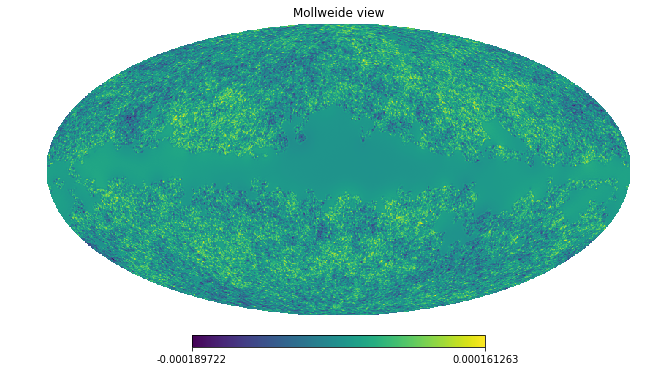

In [12]:
# filtered map
xmap = curvedsky.utils.hp_alm2map(npix,lmax,lmax,xlm0)
hp.mollview(xmap)
show()

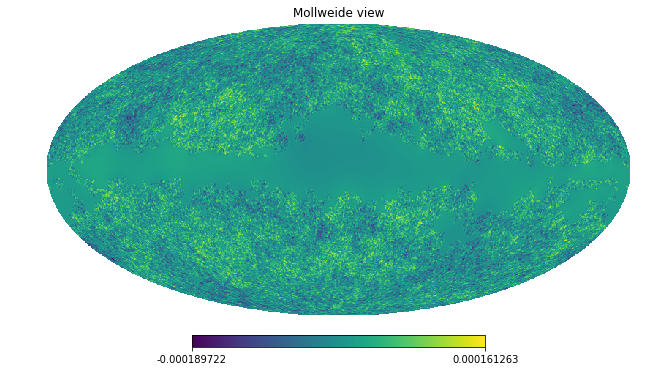

In [13]:
xmap = curvedsky.utils.hp_alm2map(npix,lmax,lmax,xlm1)
hp.mollview(xmap)
show()